# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Markdown, display
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
az_num_of_rows, az_num_of_features = azdias.shape

In [4]:
print("Number of Rows in Udacity_AZDIAS_Subset : ", az_num_of_rows)
print("Number of Columns/Features in Udacity_AZDIAS_Subset : ", az_num_of_features)

Number of Rows in Udacity_AZDIAS_Subset :  891221
Number of Columns/Features in Udacity_AZDIAS_Subset :  85


### Observation For azdias Dataset
* Number of rows/records in the dataset : 891221
* Number of columns/features in the dataset : 85

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
pd.options.display.max_columns = azdias.shape[1] # To display all cells 
azdias.describe(include = 'all')

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073,798073.000000,792242,792242,792242,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,10,45,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,8,6B,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,629528,NaN,134441,56672,133694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,NaN,4.052836,NaN,NaN,NaN,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699

### Observation
* There are missing values in some of the columns/features.
* The value in columns/features varies in the range of -1 to 2017. We will need to do feature scaling to handle it.

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

### Observation:
* The columns/features in the dataset belongs to either int64 or float64 or object Datatype. 
* 49 columns/features contains data of float64 tyoe, 32 columns/features contains data of int64 type and 4 belong 
  to object type. 

In [8]:
feat_num_of_rows, feat_num_of_features = feat_info.shape

In [9]:
print("Number of Rows in AZDIAS_Feature_Summary : ", feat_num_of_rows)
print("Number of Columns/Features in AZDIAS_Feature_Summary : ", feat_num_of_features)

Number of Rows in AZDIAS_Feature_Summary :  85
Number of Columns/Features in AZDIAS_Feature_Summary :  4


In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


### Observation:
* As we have categorical data in the azdias dataset we will need to use Feature encoding on the dataset features.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

# Lets first check the natural null in the dataset
total_natural_NAN_values = azdias.isna()

In [12]:
total_natural_NAN_values.sum().sum()

4896838

### Observation:
* Total 4896838 values are Natural NAN values in the azdias dataset

In [13]:
'''
Now lets check for AGER_TYP column and check for Nan values. As per feat_info dataset, the values in AGER_TYP 
column is Nan if it contains [-1,0]
''' 
azdias['AGER_TYP'].head(10)


0   -1
1   -1
2   -1
3    2
4   -1
5    3
6   -1
7   -1
8   -1
9   -1
Name: AGER_TYP, dtype: int64

In [14]:
# Lets count the rows in dataset where feature AGER_TYP is -1 or 0
azdias['AGER_TYP'].where(azdias.AGER_TYP.isin([-1,0])).count()

685843

In [15]:
# Natural Null in this column
azdias['AGER_TYP'].where(azdias.AGER_TYP.isnull()).count()

0

In [16]:
def convert_to_list(missing_values):
    missing_values = missing_values.strip('[]')
    missing_values = missing_values.split(',')
    return [int(m_val) if (not m_val in(['','X','XX'])) else m_val for m_val in missing_values]

In [17]:
for az_feature, miss_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
     
    missing_values = convert_to_list(miss_values)
    if (missing_values != ['']):
        azdias[az_feature] = azdias[az_feature].replace(missing_values, np.nan)

In [18]:
azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

In [19]:
# check back for the AGER_TYP column after converting to NaN, there should be no record 
# for -1 and 0 as they are Nan now
azdias['AGER_TYP'].where(azdias.AGER_TYP.isin([-1,0])).count()

0

In [20]:
azdias['AGER_TYP'].where(azdias.AGER_TYP.isna()).count()

0

In [21]:
# The count of Nan values for AGER_TYP column matches the previous count with values -1 & 0 for this column.
# This means we have successfully converted values to NaN
azdias['AGER_TYP'].isna().sum()

685843

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_in_columns = azdias.isna().sum()
print('Missing data in each column')
missing_data_in_columns

Missing data in each column


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

Text(0,0.5,'No. of Columns')

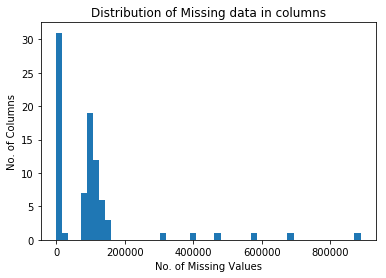

In [23]:
# missing data per column
plt.hist(missing_data_in_columns, bins = 50)
plt.title('Distribution of Missing data in columns')
plt.xlabel('No. of Missing Values')
plt.ylabel('No. of Columns')

### Observation
* We will filter out those columns that have no missing values.

In [24]:
# Investigate patterns in the amount of missing data in each column.
missing_data_in_columns_filter = azdias.isnull().sum()[azdias.isnull().sum() > 0]

missing_data_in_columns_per = (missing_data_in_columns_filter / len(azdias)) * 100

Text(0,0.5,'No. of Columns')

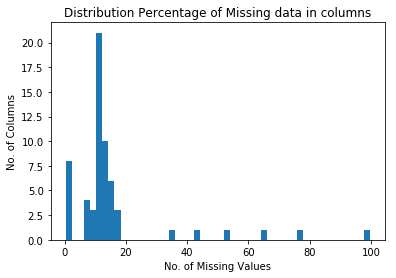

In [25]:
plt.hist(missing_data_in_columns_per, bins = 50)
plt.title('Distribution Percentage of Missing data in columns')
plt.xlabel('No. of Missing Values')
plt.ylabel('No. of Columns')

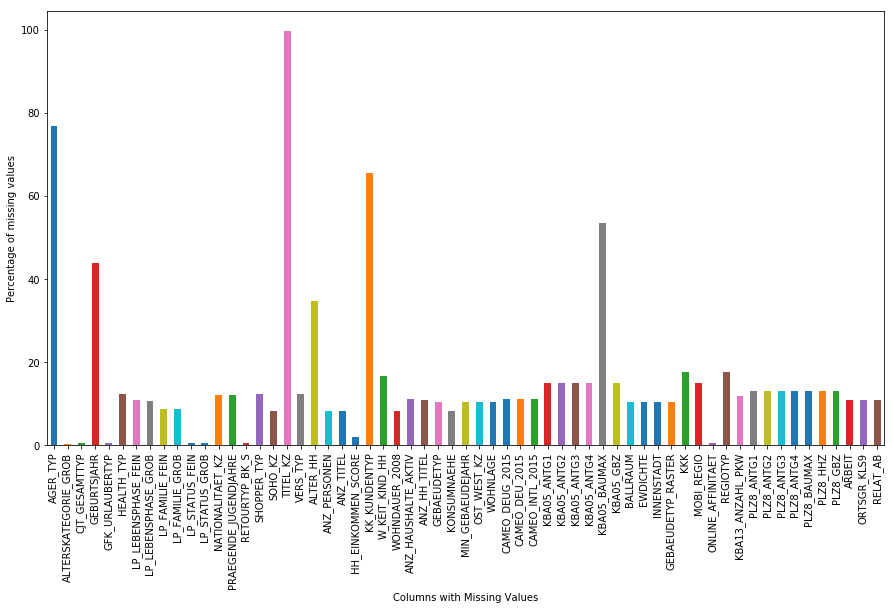

In [26]:
missing_data_in_columns_per.plot.bar(figsize=(15,8))
plt.xlabel('Columns with Missing Values')
plt.ylabel('Percentage of missing values')

plt.show()

In [27]:
'''
Lets sort the data and then view it again to make more sense of the graph
'''
missing_data_in_columns_per_sorted = missing_data_in_columns_per.sort_values(ascending = False)
missing_data_in_columns_per_sorted

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

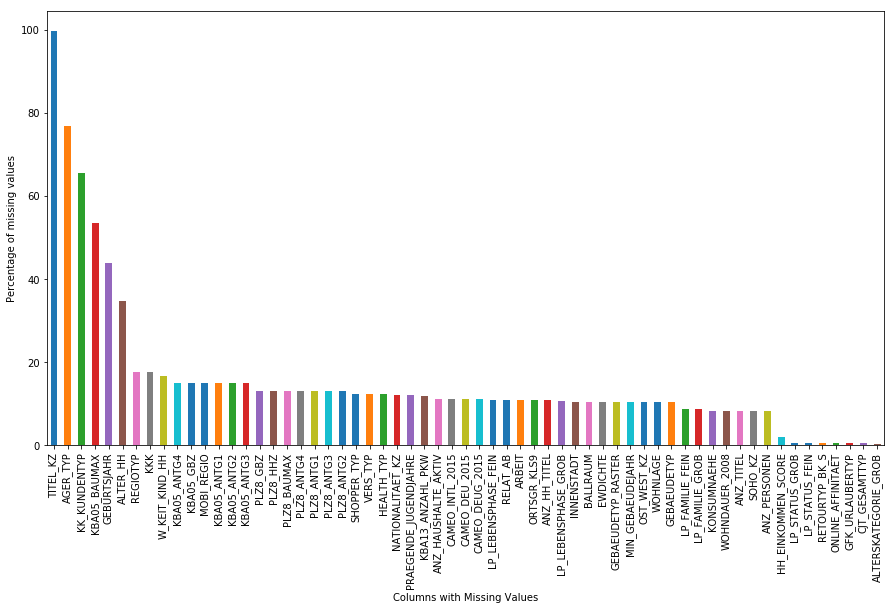

In [28]:
'''
 Now lets plot the graph again 
'''

missing_data_in_columns_per_sorted.plot.bar(figsize=(15,8))
plt.xlabel('Columns with Missing Values')
plt.ylabel('Percentage of missing values')

plt.show()

In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns_with_gt_25 = missing_data_in_columns_per[missing_data_in_columns_per > 25]
columns_with_gt_25

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [30]:
azdias.drop(columns_with_gt_25.index, axis = 1, inplace = True)

In [31]:
azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [32]:
azdias.shape

(891221, 79)

In [33]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,780025.000000,793589.000000,796649.000000,813429.000000,813429.000000,886367.000000,886367.000000,782906.000000,783057.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,817722.000000,780025.000000,891221.000000,817722.000000,817722.000000,872873.000000,743233.000000,817722.000000,791610.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,733157.000000,757897.000000,886367.000000,733157.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,7.350304,0.196612,2.190129,16.332161,4.955185,3.922339,2.381976,4.791151,2.432575,1.168889,9.280709,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.590134,0.008423,1.511166,3.362438,1.727637,0.004162,4.207243,4.147141,7.908791,8.354924,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,3.158580,4.153043,3.939172,4.549491,3.738306,2.723384,2.963540,2.698691,4.472086,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,3.525723,0.397437,0.755213,12.242378,3.748974,3.941285,1.701527,3.425305,1.474315,0.475075,4.032107,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.027972,0.091392,0.499876,1.352704,1.155849,0.068855,1.624057,1.784211,1.923137,15.673731,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.329537,2.183710,1.718996,2.028919,0.923193,0.979867,1.428882,1.521524,1.836357,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00

In [34]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column
In this section we performed the analysis on the dataset and checked for the values that are null in the data provided. During investigation we observed that some values were natural Nan in the dataset whereas we converted some values to Nan based on the feat_info data. We came to the conclusion by looking at the number of values that are null for the columns using plot as well as percentage that the below 6 columns had very high percentage of missing data.

* AGER_TYP        76.955435
* GEBURTSJAHR     44.020282
* TITEL_KZ        99.757636
* ALTER_HH        34.813699
* KK_KUNDENTYP    65.596749
* KBA05_BAUMAX    53.468668

As per my understanding, any column that is having more than a quarter of its values as null will have very less impact in our analysis, hence decided to remove any columns that are missing more than a quarter data i.e. column that is missing 25 percent of data is removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [35]:
# How much data is missing in each row of the dataset?
missing_data_in_rows = azdias.isnull().sum(axis=1)

print('Data missing in each row of the dataset: ', azdias.isnull().sum(axis=1).sum())

missing_data_in_rows

Data missing in each row of the dataset:  5035304


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [36]:
'''
Lets only consider those rows that have missing data
'''
missing_data_in_rows_filter = missing_data_in_rows[missing_data_in_rows > 0]

missing_data_in_rows_filter

0         43
3          7
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
20        10
23         8
24        47
25         5
26        19
29         2
30        34
34         4
35        43
39         5
40         4
42         2
46        40
48        47
53        43
54        47
60         4
61        43
62        43
64         5
          ..
891129     8
891130    34
891135     6
891136     2
891137    34
891139     7
891140    34
891150     3
891154    11
891155     4
891157     4
891159    43
891161     3
891162     6
891164    43
891169    18
891170    19
891171    34
891172    16
891173    19
891175    47
891181     3
891184     8
891185    47
891187    47
891203    14
891208     3
891216     3
891217     4
891218     5
Length: 268012, dtype: int64

In [37]:
'''
To have a more clear understanding about the rows missing data, lets sort the data
'''
missing_data_in_rows_filter_sorted = missing_data_in_rows_filter.sort_values(ascending=False)
missing_data_in_rows_filter_sorted

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

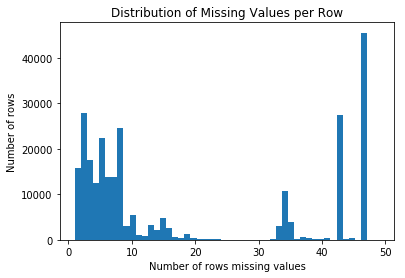

In [38]:
'''
Now lets plot the graph for these missing values
'''
plt.hist(missing_data_in_rows_filter_sorted, bins = 50)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of rows missing values')
plt.ylabel('Number of rows');

In [39]:
'''
Lets check the percentage of missing row data for columns
'''
missing_data_in_rows_filter_per = (missing_data_in_rows_filter_sorted / len(azdias.columns)) * 100
missing_data_in_rows_filter_per

732775    62.025316
643174    62.025316
472919    60.759494
604334    59.493671
604314    59.493671
768879    59.493671
604319    59.493671
604322    59.493671
604323    59.493671
275622    59.493671
62901     59.493671
275620    59.493671
604332    59.493671
275617    59.493671
604305    59.493671
275611    59.493671
275610    59.493671
62912     59.493671
604335    59.493671
604338    59.493671
604346    59.493671
604350    59.493671
146293    59.493671
604356    59.493671
62887     59.493671
768892    59.493671
146291    59.493671
348454    59.493671
604091    59.493671
604092    59.493671
            ...    
38561      1.265823
768647     1.265823
607245     1.265823
709042     1.265823
507663     1.265823
607271     1.265823
561427     1.265823
235434     1.265823
235435     1.265823
235445     1.265823
607405     1.265823
62924      1.265823
144785     1.265823
91916      1.265823
820005     1.265823
607433     1.265823
709002     1.265823
38612      1.265823
144760     1.265823


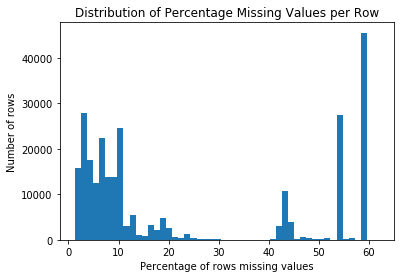

In [40]:
'''
Now lets plot the graph for these missing values
'''
plt.hist(missing_data_in_rows_filter_per, bins = 50)
plt.title('Distribution of Percentage Missing Values per Row')
plt.xlabel('Percentage of rows missing values')
plt.ylabel('Number of rows');


In [41]:
azdias.shape

(891221, 79)

### Observation:
* We observe from the plot and data that we have rows that are missing values in 50% of columns.
* We should not have problem in dropping the rows that miss values in more than 25% i.e approx 20 columns since we have 79 columns left in our dataset after removal of 6 columns with high null values. This should not impact our analysis. 

In [42]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_rows_miss_above_20 = azdias[missing_data_in_rows >= 20]
azdias_rows_miss_below_20 = azdias[missing_data_in_rows < 20]


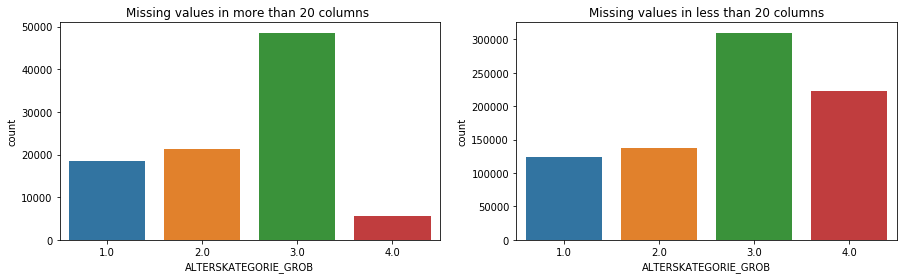

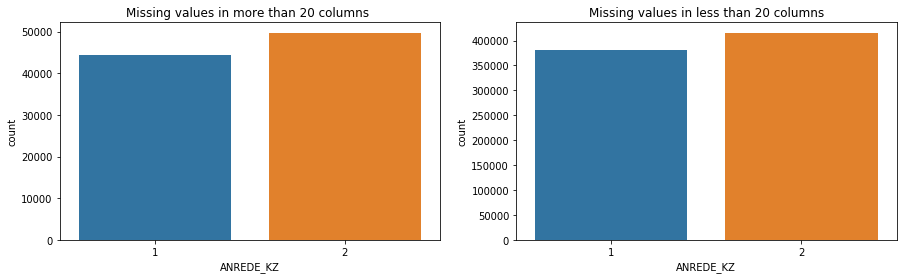

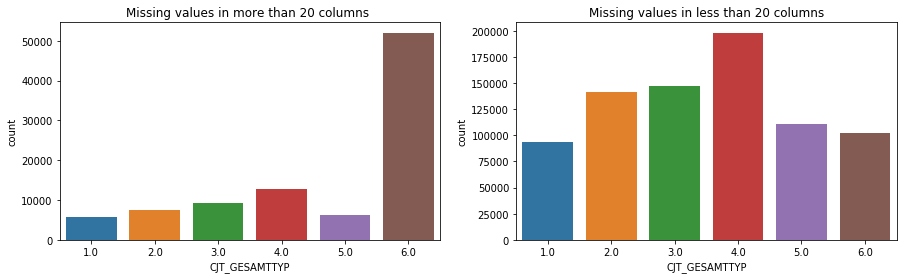

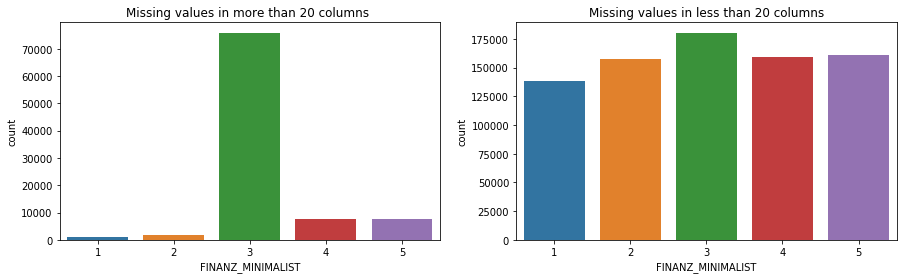

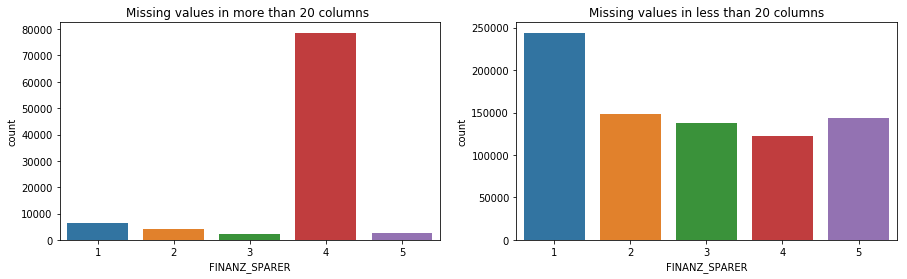

In [43]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_miss_values_plot():

    for col in azdias_rows_miss_below_20.columns[0:5]:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figwidth(15)

        sns.countplot(azdias_rows_miss_above_20.loc[:,col] , ax=ax1)
        ax1.set_title('Missing values in more than {} columns '.format(20))

        sns.countplot(azdias_rows_miss_below_20.loc[:,col] , ax=ax2)
        ax2.set_title('Missing values in less than {} columns'.format(20))
    
compare_miss_values_plot()


#### Discussion 1.1.3: Assess Missing Data in Each Row

From the plot for 5 columns we observe that only for the column ANREDE_KZ the dataset appears to have similar distribution. This indicates that droppping the columns with more than 20 columns might have some impact on the analysis. Since data with many missing values looks different than the data with few missing values, this might be a special hence we will not drop these for now.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [44]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

### Observation
* We notice that we still have 85 columns in the feat_info dataset whereas azdias has 79 as 
we removed the 6 columns that had high number of missing values. We need to remove those columns from the 
feat info dataset as well to keep it in sync with the azdias dataset.

In [45]:
feat_info_new = feat_info[~feat_info.attribute.isin(columns_with_gt_25.index)]
feat_info_new['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [46]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_new[feat_info_new.type == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [47]:
# Binary Categoricals
cat_col_list = feat_info['attribute'].iloc[feat_info_new[feat_info_new.type == 'categorical'].index]

for col in cat_col_list:
    if azdias_rows_miss_below_20[col].nunique() == 2:
        print('\nFor Column : ', col)
        print('Total Unique Values : ', azdias_rows_miss_below_20[col].nunique())
        print('Unique values : ', azdias_rows_miss_below_20[col].unique())
        print('\nTotal Records per Unique Value:')
        print(azdias_rows_miss_below_20[col].value_counts())
        print('--------------------------------')
        


For Column :  ANREDE_KZ
Total Unique Values :  2
Unique values :  [2 1]

Total Records per Unique Value:
2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
--------------------------------

For Column :  GREEN_AVANTGARDE
Total Unique Values :  2
Unique values :  [0 1]

Total Records per Unique Value:
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
--------------------------------

For Column :  SOHO_KZ
Total Unique Values :  2
Unique values :  [ 1.  0.]

Total Records per Unique Value:
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
--------------------------------

For Column :  VERS_TYP
Total Unique Values :  2
Unique values :  [  2.   1.  nan]

Total Records per Unique Value:
2.0    394116
1.0    366623
Name: VERS_TYP, dtype: int64
--------------------------------

For Column :  OST_WEST_KZ
Total Unique Values :  2
Unique values :  ['W' 'O']

Total Records per Unique Value:
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64
-----------------------------

### Observation:
* We have one binary categorical column which does not have numeric values OST_WEST_KZ, this column 
contains W, O apart from having nan value.
* We will hot encode this column.

In [48]:
# Multi Level Categoricals
for col in cat_col_list:
    if azdias_rows_miss_below_20[col].nunique() > 2:
        print('\nFor Column : ', col)
        print('Total Unique Values : ', azdias_rows_miss_below_20[col].nunique())
        print('Unique values : ', azdias_rows_miss_below_20[col].unique())
        print('\nTotal Records per Unique Value:')
        print(azdias_rows_miss_below_20[col].value_counts())
        print('--------------------------------')
        


For Column :  CJT_GESAMTTYP
Total Unique Values :  6
Unique values :  [  5.   3.   2.   4.   1.   6.  nan]

Total Records per Unique Value:
4.0    198089
3.0    147068
2.0    141166
5.0    111032
6.0    101898
1.0     93192
Name: CJT_GESAMTTYP, dtype: int64
--------------------------------

For Column :  FINANZTYP
Total Unique Values :  6
Unique values :  [1 6 5 2 4 3]

Total Records per Unique Value:
6    289004
1    196805
5    106220
2    104577
4     55874
3     44597
Name: FINANZTYP, dtype: int64
--------------------------------

For Column :  GFK_URLAUBERTYP
Total Unique Values :  12
Unique values :  [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]

Total Records per Unique Value:
12.0    129983
10.0    102748
8.0      82992
11.0     75051
5.0      70468
4.0      60413
9.0      57046
3.0      53094
1.0      50640
2.0      43647
7.0      40642
6.0      25721
Name: GFK_URLAUBERTYP, dtype: int64
--------------------------------

For Column :  LP_FAMILIE_FEIN
Total

### Observation
* The data count for each unique value of categorical data gives us an idea of how the data is categorized 
within that column. 
* For most of the columns in Multi Level categorical data, the data seems to be distributed highly for some 
values as compared to other unique values example NATIONALITAET_KZ column has 684085 records for unqiue value 1.0
whereas for other 2 unique values the number of records is ~100000.
* For the column SHOPPER_TYP we can notice the data is somewhat uniform among all the unique values. Hence, we
have decided to encode this column
* Also for the column CAMEO_DEU_2015 we have 44 unique values where data distribution among uniq values varies 
vastly (high of 56k to low of 3k). Since adding encoding to this might cause sparse values in data we will
drop this column.

In [49]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_encoded = pd.get_dummies(azdias_rows_miss_below_20, columns = ['OST_WEST_KZ','SHOPPER_TYP'])

In [51]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,0,0


In [52]:
azdias_encoded_new = azdias_encoded.drop(['CAMEO_DEU_2015'], axis=1)

In [53]:
azdias_encoded_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,8,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,4,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,2,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,6,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,7.0,8,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,0,0


In [54]:
azdias_encoded_new.shape

(797077, 82)

#### Discussion 1.2.1: Re-Encode Categorical Features

* For most of the columns in Multi Level categorical data, the data seemed to be distributed highly for some values as compared to other unique values example NATIONALITAET_KZ column has 684085 records for unqiue value 1.0 whereas for other 2 unique values the number of records is ~100000. As a result we did not encode those columns.
* For the column SHOPPER_TYP we noticed the data was somewhat uniform among all the unique values. Hence, we  decided to encode this column.
* For the column CAMEO_DEU_2015 we had 44 unique values where data distribution among unique values valried vastly (high of 56k to low of 3k). Since adding encoding to this might have caused sparse values in data wedecided to drop this column.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [55]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [56]:
display(Markdown("Data_Dictionary.md"))

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

-----

## 1. Person-level features

### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

### 1.4. CJT_GESAMTTYP
Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

### 1.6. FINANZTYP
Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

### 1.8. GFK_URLAUBERTYP
Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation

### 1.9. GREEN_AVANTGARDE
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists

### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

### 1.13. LP_FAMILIE_FEIN
Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household

### 1.14. LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

### 1.15. LP_STATUS_FEIN
Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  3: aspiring low-income earners
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners

### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

### 1.17. NATIONALITAET_KZ
Nationality based on given name analysis
- -1: unknown
-  0: unknown
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 1.19. RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

### 1.21. SHOPPER_TYP
Shopper typology
- -1: unknown
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper

### 1.22. SOHO_KZ
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

### 1.24. VERS_TYP
Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks

### 1.25. ZABEOTYP
Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown

-----

## 2. Household-level features

### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

### 2.2. ANZ_PERSONEN
Number of adults in household

### 2.3. ANZ_TITEL
Number of professional academic title holders in household

### 2.4. HH_EINKOMMEN_SCORE
Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

### 2.6. W_KEIT_KIND_HH
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely

### 2.7. WOHNDAUER_2008
Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

-----

## 3. Building-level features

### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0

### 3.2. ANZ_HH_TITEL
Number of professional academic title holders in building

### 3.3. GEBAEUDETYP
Type of building (residential vs. commercial)
- -1: unknown
-  0: unknown
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company

### 3.4. KONSUMNAEHE
Distance from building to point of sale (PoS)
- 1: building is located in a 125 x 125m grid cell (RA1), which is a
     consumption cell
- 2: building is located in a 250 x 250m grid cell that includes at least one
     RA1-consumption cell
- 3: building is located in a 500 x 500m grid cell that includes at least one
     RA1-consumption cell
- 4: building is located in a 1 x 1km grid cell that includes at least one
     RA1-consumption cell
- 5: building is located in a 2 x 2km grid cell that includes at least one
     RA1-consumption cell
- 6: building is located in a 10 x 10km grid cell that includes at least one
     RA1-consumption cell
- 7: building is not located in a 10 x 10km range of a consumption cell

### 3.5. MIN_GEBAEUDEJAHR
First year building was mentioned in the database
- missing values encoded by 0

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

-----

## 4. RR4 micro-cell features

### 4.1. CAMEO_DEUG_2015
German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  2: upper middleclass
-  3: established middleclass
-  4: consumption-oriented middleclass
-  5: active middleclass
-  6: low-consumption middleclass
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown

### 4.2. CAMEO_DEU_2015
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

-----

## 5. RR3 micro-cell features

### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 5.2. KBA05_ANTG2
Number of 3-5 family houses in the microcell
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 5.3. KBA05_ANTG3
Number of 6-10 family houses in the microcell
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 5.4. KBA05_ANTG4
Number of 10+ family houses in the microcell
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

### 5.6. KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

-----

## 6. Postcode-level features

### 6.1. BALLRAUM
Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km

### 6.2. EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

### 6.3. INNENSTADT
Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center

-----

## 7. RR1 region features

### 7.1. GEBAEUDETYP_RASTER
Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell

### 7.2. KKK
Purchasing power in region
- -1; unknown
-  0: unknown
-  1: very high
-  2: high
-  3: average
-  4: low

### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

### 7.4. ONLINE_AFFINITAET
Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest

### 7.5. REGIOTYP
Neighborhood typology
- -1: unknown
-  0: unknown
-  1: upper class
-  2: conservatives
-  3: upper middle class
-  4: middle class
-  5: lower middle class
-  6: traditional workers
-  7: marginal groups

-----

## 8. PLZ8 macro-cell features

### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 8.3. PLZ8_ANTG2
Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

### 8.7. PLZ8_HHZ
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

-----

## 9. Community-level features

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants

### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown


### Observation from Data_Dictionary.md
1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
* -1: unknown
* 0: unknown
* 1: 40s - war years (Mainstream, E+W)
* 2: 40s - reconstruction years (Avantgarde, E+W)
* 3: 50s - economic miracle (Mainstream, E+W)
* 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
* 5: 60s - economic miracle (Mainstream, E+W)
* 6: 60s - generation 68 / student protestors (Avantgarde, W)
* 7: 60s - opponents to the building of the Wall (Avantgarde, E)
* 8: 70s - family orientation (Mainstream, E+W)
* 9: 70s - peace movement (Avantgarde, E+W)
* 10: 80s - Generation Golf (Mainstream, W)
* 11: 80s - ecological awareness (Avantgarde, W)
* 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
* 13: 80s - Swords into ploughshares (Avantgarde, E)
* 14: 90s - digital media kids (Mainstream, E+W)
* 15: 90s - ecological awareness (Avantgarde, E+W)


In [57]:
# Mainstream belongs to these codes other codes belong to Avantgarde. 
# We had already taken care of -1 & 0 for unknown in the previous steps
mainstream_code = [1, 3, 5, 8, 10, 12, 14]

def map_mainstream(x):
    if x in mainstream_code:
        return 1
    else:
        return 0
    
# Creating Movement variable    
azdias_encoded_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_encoded_new['PRAEGENDE_JUGENDJAHRE'].apply(map_mainstream)


In [58]:
# Generations by decades belong to these codes 40 have 1 & 2, 50 have 3 & 4 etc.
generation_code = {1:[1, 2], 2:[3, 4], 3:[5, 6, 7], 4:[8, 9], 5:[10, 11, 12, 13], 6:[14, 15]}

def map_generation(x):
    for key, val in generation_code.items():
        if x in val:
            return key

# Creating Generation by Decade variable
azdias_encoded_new['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = azdias_encoded_new['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)


In [59]:
# Drop the original column
azdias_encoded_new.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [60]:
azdias_encoded_new.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,8,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,1,1,6.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,4,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0,0,6.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,2,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0,1,4.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,6,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0,1,4.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,7.0,8,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,0,0,1,2.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,5.0,4,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1,0,1,0,0,1,5.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,1.0,2,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0,1,1,0,0,0,1,4.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,1.0,1,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0,1,0,0,0,1,0,5.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,7.0,1,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0,1,0,0,0,1,0,6.0
10,3.0,2,1.0,2,2,5,3,1,5,6,8.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,5.0,9,51,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0,1,2.0


### Observation for CAMEO_INTL_2015 from Data_Dictionary.md

4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
* -1: unknown
* 11: Wealthy Households - Pre-Family Couples & Singles
* 12: Wealthy Households - Young Couples With Children
* 13: Wealthy Households - Families With School Age Children
* 14: Wealthy Households - Older Families & Mature Couples
* 15: Wealthy Households - Elders In Retirement
* 21: Prosperous Households - Pre-Family Couples & Singles
* 22: Prosperous Households - Young Couples With Children
* 23: Prosperous Households - Families With School Age Children
* 24: Prosperous Households - Older Families & Mature Couples
* 25: Prosperous Households - Elders In Retirement
* 31: Comfortable Households - Pre-Family Couples & Singles
* 32: Comfortable Households - Young Couples With Children
* 33: Comfortable Households - Families With School Age Children
* 34: Comfortable Households - Older Families & Mature Couples
* 35: Comfortable Households - Elders In Retirement
* 41: Less Affluent Households - Pre-Family Couples & Singles
* 42: Less Affluent Households - Young Couples With Children
* 43: Less Affluent Households - Families With School Age Children
* 44: Less Affluent Households - Older Families & Mature Couples
* 45: Less Affluent Households - Elders In Retirement
* 51: Poorer Households - Pre-Family Couples & Singles
* 52: Poorer Households - Young Couples With Children
* 53: Poorer Households - Families With School Age Children
* 54: Poorer Households - Older Families & Mature Couples
* 55: Poorer Households - Elders In Retirement
* XX: unknown


In [61]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Creating wealth variable
def map_wealth(x):
    if pd.isnull(x):
        return x
    else:
        return int(x[1])

azdias_encoded_new['WEALTH'] = azdias_encoded_new['CAMEO_INTL_2015']
azdias_encoded_new['WEALTH'] = azdias_encoded_new['WEALTH'].apply(map_wealth)


In [62]:
# Creating Lifestage Variable

def map_lifestage(x):
    if pd.isnull(x):
        return x
    else:
        return int(x[0])

azdias_encoded_new['LIFE_STAGE'] = azdias_encoded_new['CAMEO_INTL_2015']
azdias_encoded_new['LIFE_STAGE'] = azdias_encoded_new['LIFE_STAGE'].apply(map_lifestage)


In [63]:
# Drop the original column
azdias_encoded_new.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [64]:
azdias_encoded_new.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,8,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,1,1,6.0,1.0,5.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,4,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0,0,6.0,4.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,2,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0,1,4.0,2.0,1.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,6,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0,1,4.0,3.0,4.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,7.0,8,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,0,0,1,2.0,4.0,5.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,5.0,4,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1,0,1,0,0,1,5.0,2.0,2.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,1.0,2,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0,1,1,0,0,0,1,4.0,4.0,1.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,1.0,1,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0,1,0,0,0,1,0,5.0,3.0,1.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,7.0,1,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0,1,0,0,0,1,0,6.0,5.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,8.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,5.0,9,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0,0,1,0,1,2.0,1.0,5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For column "PRAEGENDE_JUGENDJAHRE", we created 2 new columns "PRAEGENDE_JUGENDJAHRE_MOVEMENT" & "PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE". 
* The column PRAEGENDE_JUGENDJAHRE_MOVEMENT was created for movement data and column PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE for generation by decade data. 
* The value 1 in the column "PRAEGENDE_JUGENDJAHRE_MOVEMENT" refer to mainstream and 0 refers to avantgarde.
* The values for PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE are given in interval and we have assigned code 1 to 6 to represent decades 40,50,60,70,80,90.

For column "CAMEO_INTL_2015", we created 2 new columns "WEALTH" & "LIFE_STAGE"
* We have broken the code into tens and units places as required and assigned tens code to Wealth and units code 
for LIFE_STAGE

* We have dropped original columns "PRAEGENDE_JUGENDJAHRE" & "CAMEO_INTL_2015" to avoide repeatation of same data.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for az_feature, miss_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_values = convert_to_list(miss_values)
        if (missing_values != ['']):
            df[az_feature] = df[az_feature].replace(missing_values, np.nan)
    
    # remove selected columns and rows, ...
    columns_miss_gt_25 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(columns_miss_gt_25, axis=1, inplace=True)
    
    feat_info_new = feat_info[~feat_info.attribute.isin(columns_miss_gt_25)]
                    
    missing_data_in_rows = df.isnull().sum(axis=1)
    
    df_rows_miss_above_20 = df[missing_data_in_rows >= 20]
    df_rows_miss_below_20 = df[missing_data_in_rows < 20]

    # select, re-encode, and engineer column values.
    df_encoded = pd.get_dummies(df_rows_miss_below_20, columns = ['OST_WEST_KZ','SHOPPER_TYP'])
    df_encoded_new = df_encoded.drop(['CAMEO_DEU_2015'], axis=1)
    
    df_encoded_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_encoded_new['PRAEGENDE_JUGENDJAHRE'].apply(map_mainstream)
    df_encoded_new['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = df_encoded_new['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)
    df_encoded_new.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

    df_encoded_new['WEALTH'] = df_encoded_new['CAMEO_INTL_2015']
    df_encoded_new['WEALTH'] = df_encoded_new['WEALTH'].apply(map_wealth)
    df_encoded_new['LIFE_STAGE'] = df_encoded_new['CAMEO_INTL_2015']
    df_encoded_new['LIFE_STAGE'] = df_encoded_new['LIFE_STAGE'].apply(map_lifestage)
    df_encoded_new.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_encoded_new
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [68]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Total Records: ',azdias_encoded_new.shape[0])
print('Total Null Values: ',azdias_encoded_new.isna().sum().sum())


Total Records:  797077
Total Null Values:  956144


### Observation:
* We have high number of values as nan in our dataset, we can make use of imputer to fill these 
values instead of dropping them.

In [69]:
data_imputer = Imputer(strategy = 'mean')
imputed_values = data_imputer.fit_transform(azdias_encoded_new)
azdias_encoded_new_imputed = pd.DataFrame(imputed_values, columns=azdias_encoded_new.columns)

In [70]:
print('Total Records: ',azdias_encoded_new_imputed.shape[0])
print('Total Null Values: ',azdias_encoded_new_imputed.isna().sum().sum())

Total Records:  797077
Total Null Values:  0


In [71]:
# Apply feature scaling to the general population demographics data.

azdias_data_scaler = StandardScaler()
azdias_scaled_data = azdias_data_scaler.fit_transform(azdias_encoded_new_imputed)
azdias_scaled_data = pd.DataFrame(azdias_scaled_data, columns=azdias_encoded_new_imputed.columns)

In [72]:
azdias_scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,WEALTH,LIFE_STAGE
0,-1.765596,0.958121,0.976808,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-1.342762,0.709607,-0.530654,1.085338,0.396102,2.899371e-01,2.819936e-01,3.736779e-01,-0.794783,-0.968465,-0.362769,-1.684255,0.442419,-0.059134,0.003319,-0.463253,-1.685220,-1.109821,-1.435509,-0.578571,1.274161,-0.311629,1.339150,-0.157497,1.517954,1.288519,10.855531,0.987257,1.151377,0.233692,-0.060579,1.025749,-6.787621e-01,0.566381,0.169103,-0.125737,1.956725,-1.304502,-0.383149,-0.027783,0.992231,-1.091498,-1.042336,-0.631981,2.719967,-1.665001,0.846136,-0.546786,1.701390,-0.799697,-7.699342e-01,-1.409254,0.172167,-8.360506e-01,1.017489,-0.264358,0.218380,0.415885,0.419651,-0.655950,1.444681,0.564771,-0.167603,-0.127894,0.684425,-0.517521,0.517521,-0.435573,-0.670394,-0.590109,1.847538,0.585443,1.165504,-1.265981,1.190696
1,0.201448,0.958121,-0.327880,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,-1.342762,0.709607,1.884467,1.085338,-1.124434,-1.086781e+00,-7.544547e-01,-8.267027e-01,-0.509918,-0.305066,-0.362769,-0.305234,-0.072758,-1.626956,-0.520178,-0.463253,-0.142659,-0.158824,0.754224,-0.578571,0.064325,1.393241,1.339150,1.448591,-0.638498,-0.410737,-0.092119,-1.061291,1.151377,-0.631113,-0.060579,-0.268726,-6.787621e-01,0.566381,0.105075,-0.125737,-0.677237,1.275106,-0.383149,-1.054519,-0.620217,-0.361046,1.428461,0.379943,-0.491198,-0.122300,-0.986223,0.035170,-0.270756,0.283627,-7.699342e-01,0.026186,-0.472400,-1.403948e+00,0.273655,0.779197,0.218380,-0.612094,-0.975329,-0.655950,0.403229,0.564771,-0.167603,-0.127894,-0.789527,-0.517521,0.517521,-0.435573,-0.670394,1.694601,-0.541261,-1.708107,1.165504,0.761849,-0.865318
2,1.184971,0.958121,-0.980223,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,1.055589,-1.815506,-0.530654,-0.270203,0.000000,2.445542e-16,4.602755e-16,-2.665380e-16,1.199274,1.021732,-0.362769,-0.994744,0.442419,-1.626956,-1.043675,-1.508398,-0.142659,-0.158824,1.301657,-0.067846,-0.540594,-0.311629,-0.303505,0.377866,-0.099385,0.155682,-0.092119,-1.061291,-0.269246,-1.495919,-0.060579,-2.210438,5.188301e-16,0.566381,-0.471175,-0.125737,-0.677237,0.630204,1.139883,1.512320,-1.426441,1.830308,-0.218737,-0.631981,-0.491198,0.649050,-0.070043,-1.128741,0.715317,0.283627,4.726364e-16,0.743906,-1.116968,1.008788e-15,-0.070109,-0.264358,-0.883799,0.415885,-0.975329,-0.655950,-0.638223,0.564771,-1.171230,-0.998469,-0.052551,-0.517521,0.517521,-0.435573,1.491659,-0.590109,-0.541261,0.585443,-0.231903,-0.590038,-1.550656
3,0.201448,-1.043709,0.976808,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,0.575919,-0.693234,-0.530654,1.085338,1.325318,1.391312e+00,1.577554e+00,1.574059e+00,-0.509918,-0.305066,-0.362769,1.073787,0.957596,-0.059134,0.003319,-0.985825,1.399902,-0.158824,-0.340642,0.953604,-1.145512,-0.879919,-1.398609,-1.228222,-0.099385,-0.977156,-0.092119,0.987257,0.441065,1.

### Discussion 2.1: Apply Feature Scaling

We had high number of values in the dataset and removing them would have impacted the scaling. As a result we
used Imputer to replace the missing values or NaN from the dataset. We used the mean strategy to impute the missing values in the dataset. 
Since the dataset also had varying values in the columns that would have impacted the performance of our analysis, hence used StandardScaler to scale the data with unit variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(azdias_scaled_data)


array([[  3.73619682e+00,  -3.29122404e+00,  -3.05473695e+00, ...,
         -3.14792488e-02,  -1.17603345e-01,   6.46691826e-15],
       [ -1.01947428e-02,   2.96226750e-01,  -3.54180964e+00, ...,
         -2.74679993e-02,   2.10479614e-02,   5.33372064e-15],
       [ -4.42673515e+00,   1.89930244e+00,  -5.80216684e-01, ...,
         -5.21088574e-02,   4.24302630e-02,   1.89582191e-17],
       ..., 
       [ -8.22422697e-01,  -3.39717894e+00,  -3.23033766e+00, ...,
          3.45962771e-02,  -6.39375275e-02,  -1.16445099e-16],
       [  5.35225309e+00,  -4.41554566e+00,   2.66412489e+00, ...,
         -9.40082593e-03,   5.62695898e-02,   3.51014709e-18],
       [  4.98213245e-01,   1.79320400e+00,   2.86058311e+00, ...,
          5.13180422e-02,   1.42200258e-03,  -1.16700988e-16]])

In [74]:
print('Ratio of Variance \n', pca.explained_variance_ratio_)

Ratio of Variance 
 [  1.67979257e-01   1.09849208e-01   7.59953714e-02   5.50880112e-02
   4.25288367e-02   3.20142735e-02   2.63358533e-02   2.27884207e-02
   2.13515581e-02   2.00928815e-02   1.91865448e-02   1.83421982e-02
   1.66960148e-02   1.58073850e-02   1.46119730e-02   1.39762569e-02
   1.38624927e-02   1.32920076e-02   1.25179945e-02   1.19092932e-02
   1.17994970e-02   1.12268292e-02   1.10495871e-02   1.07589811e-02
   1.05605492e-02   1.01216677e-02   9.93761610e-03   9.68112383e-03
   9.25241759e-03   9.01671604e-03   8.80059694e-03   8.22610718e-03
   7.97219986e-03   7.77402910e-03   7.39527146e-03   6.70861291e-03
   6.28035626e-03   5.92481232e-03   5.79602375e-03   5.48056589e-03
   5.39408061e-03   5.18904703e-03   5.04364432e-03   4.92992123e-03
   4.70900093e-03   4.45499366e-03   4.09281256e-03   4.05714723e-03
   3.74902513e-03   3.39174488e-03   3.30492807e-03   3.22642766e-03
   3.14499847e-03   3.04526156e-03   2.95552703e-03   2.90012962e-03
   2.82714784e

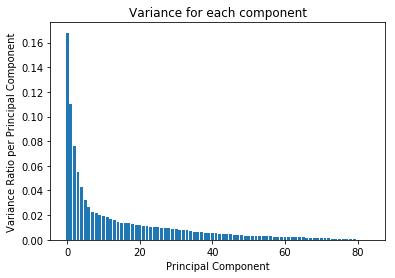

In [75]:
# Investigate the variance accounted for by each principal component.
num_of_components = range(len(pca.explained_variance_ratio_))
var_ratio = pca.explained_variance_ratio_

plt.bar(num_of_components, var_ratio)
plt.title("Variance for each component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio per Principal Component")
plt.show()


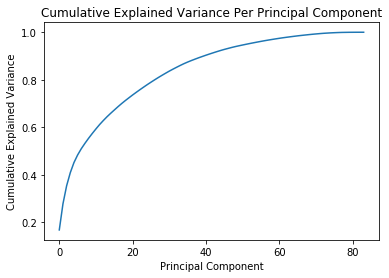

In [76]:
cumul_values = np.cumsum(var_ratio)
plt.plot(num_of_components, cumul_values)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component");

In [77]:
print('Cumulative Explained Variance \n',pca.explained_variance_ratio_.sum())

Cumulative Explained Variance 
 1.0


### Observation
* Currently using all the components we can see that we are able to get Cumulative Explained Variance of 1.0
and since we are using all the components in PCA it means we are getting 100 percent variability for the data
when using all the components.

In [78]:
# Now lets check the percent of variance we get for different number of components
for num_of_comp in range(5, len(pca.explained_variance_ratio_), 5):
    tot_var = pca.explained_variance_ratio_[:num_of_comp].sum()
    print('For {} components, Variance is {}'.format(num_of_comp, tot_var))

For 5 components, Variance is 0.4514406847233381
For 10 components, Variance is 0.5740236718558306
For 15 components, Variance is 0.6586677878433906
For 20 components, Variance is 0.724225832743309
For 25 components, Variance is 0.779621276328131
For 30 components, Variance is 0.8276308175665578
For 35 components, Variance is 0.8677990221170148
For 40 components, Variance is 0.8979893932408534
For 45 components, Variance is 0.9232550873739044
For 50 components, Variance is 0.9430008108347051
For 55 components, Variance is 0.9586779536109825
For 60 components, Variance is 0.9720811262301143
For 65 components, Variance is 0.9828800237846824
For 70 components, Variance is 0.9914336074815042
For 75 components, Variance is 0.9973451714521298
For 80 components, Variance is 0.9997498192315685


### Observation
* We can observe that with just 40 components we can get ~89% of the variability in the data. This means by just 
using 40 features from the dataset we can capture apporx 89% of the variability. We will be using this number of 
components for our further use.


In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components = 40)
azdias_scaled_data_pca_40 = pca_40.fit_transform(azdias_scaled_data)

In [80]:
# Ratio of variance with 40 components
print('Ratio of Variance \n', pca_40.explained_variance_ratio_)

Ratio of Variance 
 [ 0.16797926  0.10984921  0.07599537  0.05508801  0.04252884  0.03201427
  0.02633585  0.02278842  0.02135155  0.02009288  0.01918654  0.0183422
  0.016696    0.0158073   0.01461195  0.01397622  0.01386247  0.01329179
  0.01251784  0.01190916  0.01179931  0.01122673  0.01104937  0.01075889
  0.01056008  0.01012105  0.00993727  0.00967995  0.00925216  0.00901549
  0.00879982  0.00822506  0.00796993  0.00777353  0.00739053  0.00670423
  0.00622893  0.00590906  0.00578855  0.00546225]


In [81]:
# Cumulative Explained Variance with 40 components
print('Cumulative Explained Variance \n', pca_40.explained_variance_ratio_.sum())

Cumulative Explained Variance 
 0.897877314001


### Discussion 2.2: Perform Dimensionality Reduction

We observed that when we used PCA with all the components we were capturing 100% of variability in the dataset. On further analysis we found that with just 40 components we can get ~89% of the variability in the data. So by reducing our components from 84 to 40 (i.e. more than 50% of reduction in dimensions), we can still get 89% of the variability in the data. Hence we decided on using 40 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Mapping weight with features
df = pd.DataFrame(pca_40.components_, columns=azdias_scaled_data.columns)

In [83]:
df.shape

(40, 84)

In [84]:
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,WEALTH,LIFE_STAGE
0,-0.075537,0.015348,0.028873,-0.189985,0.103461,-0.075413,0.042355,0.040198,0.158529,-0.045471,0.057220,-0.106543,0.023740,-0.148750,-0.135400,-0.101396,-0.103548,-0.213614,-0.211143,0.047065,-0.000775,0.024501,0.048193,0.070276,0.051077,-0.042987,-0.044562,-0.041120,0.039486,0.062544,0.019692,0.026397,0.042317,0.074967,0.052595,-0.002350,0.025067,0.127557,-0.098190,-0.004804,0.191477,0.059670,-0.051206,0.121228,0.029517,0.067201,-0.145417,-0.049414,-0.068038,0.192600,-0.201887,0.010670,0.121539,0.134535,-0.192167,-0.104774,0.165384,-0.138222,-0.102355,0.039268,-0.215499,-0.066877,0.063726,-0.067454,-0.197277,0.133462,0.196535,0.190859,0.186469,0.036138,-0.145790,0.123843,0.167586,0.115208,0.050537,-0.050537,-0.023040,0.000111,0.035827,-0.031446,0.090886,0.061659,-0.109799,0.189801
1,0.265784,0.072211,-0.128605,0.100459,-0.248964,0.237877,-0.209804,-0.232087,0.085754,0.117080,-0.042945,0.000529,-0.059172,-0.036593,-0.045138,-0.074014,-0.075226,-0.013008,0.005824,-0.076285,0.161710,-0.093838,-0.177086,-0.256171,-0.161801,-0.048849,0.185077,0.223400,-0.210375,-0.181650,0.101969,0.054544,0.089132,-0.235150,-0.232896,-0.001724,0.025372,-0.032044,-0.064514,0.006920,0.024785,0.122816,0.062618,0.040312,0.024654,0.006393,-0.041449,-0.038657,-0.036662,0.037825,-0.041420,-0.010682,0.020106,0.042662,-0.050189,-0.036645,0.056466,-0.045292,-0.025374,-0.005144,-0.048129,-0.161601,0.007525,-0.024028,-0.053949,0.036982,0.055201,0.052739,0.049189,0.005270,-0.044743,0.044952,0.055736,0.040657,0.023673,-0.023673,-0.064492,-0.033454,0.007489,0.092973,-0.005985,-0.256903,0.019870,0.042724
2,0.059091,-0.360072,-0.035174,0.147063,-0.089757,0.081932,-0.169667,-0.089725,-0.044431,0.112686,-0.020194,0.042872,-0.019911,-0.009723,-0.012481,-0.025526,-0.027242,0.022773,0.036733,-0.023148,0.096014,0.260183,0.252666,0.083642,0.062657,0.334332,0.049493,-0.186619,0.239616,-0.198803,-0.272292,-0.307857,-0.332204,-0.062612,-0.061850,0.000244,0.012320,-0.060181,-0.014436,0.008627,-0.018147,0.088528,0.026558,0.024109,0.012066,0.008973,-0.035170,-0.014906,-0.017596,0.028888,-0.021055,-0.012247,0.005525,0.025549,-0.022445,-0.031078,0.041175,-0.040166,-0.030362,-0.013305,-0.026356,-0.049329,-0.005209,-0.026570,-0.046717,0.026281,0.043886,0.045815,0.049464,0.000970,-0.041436,0.037261,0.043698,0.029268,0.026495,-0.026495,0.129794,0.052613,-0.101818,-0.046762,-0.031750,-0.090732,-0.011258,0.028649
3,-0.000688,0.023878,0.067298,0.026535,-0.003719,0.000829,-0.052241,0.003422,-0.033781,0.021463,-0.027123,0.173705,-0.012332,0.324878,0.332532,0.340014,0.342431,0.047232,0.062488,0.011676,0.008618,0.010073,-0.023841,-0.017716,-0.017518,-0.006000,0.019542,0.013124,-0.021103,0.009690,-0.031488,0.063110,0.063976,-0.003786,-0.004626,0.004286,0.017277,-0.084140,0.287324,0.027535,-0.097128,-0.210475,0.074482,0.029163,0.026850,0.012825,-0.105272,-0.017295,-0.155257,0.011749,

In [85]:
# Checking the first component feature weights
df.iloc[0]

ALTERSKATEGORIE_GROB                  -0.075537
ANREDE_KZ                              0.015348
CJT_GESAMTTYP                          0.028873
FINANZ_MINIMALIST                     -0.189985
FINANZ_SPARER                          0.103461
FINANZ_VORSORGER                      -0.075413
FINANZ_ANLEGER                         0.042355
FINANZ_UNAUFFAELLIGER                  0.040198
FINANZ_HAUSBAUER                       0.158529
FINANZTYP                             -0.045471
GFK_URLAUBERTYP                        0.057220
GREEN_AVANTGARDE                      -0.106543
HEALTH_TYP                             0.023740
LP_LEBENSPHASE_FEIN                   -0.148750
LP_LEBENSPHASE_GROB                   -0.135400
LP_FAMILIE_FEIN                       -0.101396
LP_FAMILIE_GROB                       -0.103548
LP_STATUS_FEIN                        -0.213614
LP_STATUS_GROB                        -0.211143
NATIONALITAET_KZ                       0.047065
RETOURTYP_BK_S                        -0

In [86]:
# sorting the weights
df.iloc[0].sort_values(ascending=False)

PLZ8_ANTG3                             0.196535
CAMEO_DEUG_2015                        0.192600
HH_EINKOMMEN_SCORE                     0.191477
PLZ8_ANTG4                             0.190859
LIFE_STAGE                             0.189801
PLZ8_BAUMAX                            0.186469
ORTSGR_KLS9                            0.167586
EWDICHTE                               0.165384
FINANZ_HAUSBAUER                       0.158529
KBA05_ANTG4                            0.134535
PLZ8_ANTG2                             0.133462
ZABEOTYP                               0.127557
ARBEIT                                 0.123843
KBA05_ANTG3                            0.121539
ANZ_HAUSHALTE_AKTIV                    0.121228
RELAT_AB                               0.115208
FINANZ_SPARER                          0.103461
PRAEGENDE_JUGENDJAHRE_MOVEMENT         0.090886
SEMIO_PFLICHT                          0.074967
SEMIO_REL                              0.070276
GEBAEUDETYP                            0

In [87]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# now lets create a function based on our analysis above

def pca_feature_weights(df, pca, feature_num):
    df = pd.DataFrame(pca.components_, columns=df.columns)
    pca_feature_weights = df.iloc[feature_num].sort_values(ascending=False)
    
    return pca_feature_weights


In [88]:
pca_weight_first_comp = pca_feature_weights(azdias_scaled_data, pca_40, 0)

print('Weights of First Components Sorted in Ascending:\n')
print(pca_weight_first_comp)

Weights of First Components Sorted in Ascending:

PLZ8_ANTG3                             0.196535
CAMEO_DEUG_2015                        0.192600
HH_EINKOMMEN_SCORE                     0.191477
PLZ8_ANTG4                             0.190859
LIFE_STAGE                             0.189801
PLZ8_BAUMAX                            0.186469
ORTSGR_KLS9                            0.167586
EWDICHTE                               0.165384
FINANZ_HAUSBAUER                       0.158529
KBA05_ANTG4                            0.134535
PLZ8_ANTG2                             0.133462
ZABEOTYP                               0.127557
ARBEIT                                 0.123843
KBA05_ANTG3                            0.121539
ANZ_HAUSHALTE_AKTIV                    0.121228
RELAT_AB                               0.115208
FINANZ_SPARER                          0.103461
PRAEGENDE_JUGENDJAHRE_MOVEMENT         0.090886
SEMIO_PFLICHT                          0.074967
SEMIO_REL                             

In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_second_comp = pca_feature_weights(azdias_scaled_data, pca_40, 1)

print('Weights of Second Components Sorted in Ascending:\n')
print(pca_weight_second_comp)


Weights of Second Components Sorted in Ascending:

ALTERSKATEGORIE_GROB                   0.265784
FINANZ_VORSORGER                       0.237877
SEMIO_ERL                              0.223400
SEMIO_LUST                             0.185077
RETOURTYP_BK_S                         0.161710
W_KEIT_KIND_HH                         0.122816
FINANZTYP                              0.117080
SEMIO_KRIT                             0.101969
FINANZ_MINIMALIST                      0.100459
SHOPPER_TYP_3.0                        0.092973
SEMIO_KAEM                             0.089132
FINANZ_HAUSBAUER                       0.085754
ANREDE_KZ                              0.072211
WOHNDAUER_2008                         0.062618
EWDICHTE                               0.056466
ORTSGR_KLS9                            0.055736
PLZ8_ANTG3                             0.055201
SEMIO_DOM                              0.054544
PLZ8_ANTG4                             0.052739
PLZ8_BAUMAX                          

In [90]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_third_comp = pca_feature_weights(azdias_scaled_data, pca_40, 2)

print('Weights of Third Components Sorted in Ascending:\n')
print(pca_weight_third_comp)


Weights of Third Components Sorted in Ascending:

SEMIO_VERT                             0.334332
SEMIO_SOZ                              0.260183
SEMIO_FAM                              0.252666
SEMIO_KULT                             0.239616
FINANZ_MINIMALIST                      0.147063
SHOPPER_TYP_0.0                        0.129794
FINANZTYP                              0.112686
RETOURTYP_BK_S                         0.096014
W_KEIT_KIND_HH                         0.088528
SEMIO_REL                              0.083642
FINANZ_VORSORGER                       0.081932
SEMIO_MAT                              0.062657
ALTERSKATEGORIE_GROB                   0.059091
SHOPPER_TYP_1.0                        0.052613
SEMIO_LUST                             0.049493
PLZ8_BAUMAX                            0.049464
PLZ8_ANTG4                             0.045815
PLZ8_ANTG3                             0.043886
ORTSGR_KLS9                            0.043698
GREEN_AVANTGARDE                      

### Discussion 2.3: Interpret Principal Components

#### First Principal Components

Positive Weights : 
* PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
* CAMEO_DEUG_2015 (Wealth / Life Stage Typology, rough scale) 

Negative Weights :
* MOBI_REGI (Movement patterns)

There is a positive correlation among the features PLZ8_ANTG3 & CAMEO_DEUG_2015 which means that as number of 6-10 family houses increases, the wealth also increases.

There is negative correlation between features PLZ8_ANTG3 & MOBI_REGI which means that as movement increases, number of 6-10 houses decreases.

#### Scond Principal Components

Positive Weights : 
* ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
* FINANZ_VORSORGER (Financial typology: be prepared)

Negative Weights :
* PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE

Features ALTERSKATEGORIE_GROB & FINANZ_VORSORGER are positively correlated which tells us that with the increase in age financial topology tends to increase as well while the create feature PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE representing generations by decade is negatively correlated. 

#### Third Principal Components

Positive Weights : 
* SEMIO_VERT (Personality typology: dreamful)
* SEMIO_SOZ  (Personality typology: socially-minded)

Negative Weights :
* ANREDE_KZ (Gender)

Features SEMIO_VERT & SEMIO_SOZ are positively correalted i.e. the more dreamful the person is the more socially minded the person is.

Features SEMIO_VERT & ANREDE_KZ are negatively correalted i.e. how dreamful a person is varies with which gender the person belongs to.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [91]:
from sklearn.cluster import KMeans

num_of_clusters = list(range(2, 21, 2))
scores = []

# Over a number of different cluster counts...
for n_clusters in num_of_clusters:
    
    k_means = KMeans(n_clusters = n_clusters)
    
    # run k-means clustering on the data and...
    k_means_model = k_means.fit(azdias_scaled_data_pca_40)
    
    # compute the average within-cluster distances.
    k_means_score = np.abs(k_means_model.score(azdias_scaled_data_pca_40))
    scores.append(k_means_score)
    print('For {} clusters, the score is {}'.format(n_clusters, k_means_score))
    
    

For 2 clusters, the score is 51597260.608781
For 4 clusters, the score is 45792118.30596869
For 6 clusters, the score is 42984218.16124712
For 8 clusters, the score is 40782452.51272921
For 10 clusters, the score is 39375143.40184945
For 12 clusters, the score is 38428880.892452605
For 14 clusters, the score is 37293963.539859556
For 16 clusters, the score is 36930141.148911476
For 18 clusters, the score is 36125108.74928126
For 20 clusters, the score is 35328873.88999447


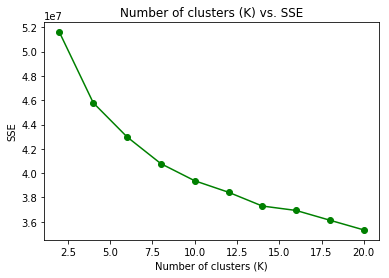

In [92]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(num_of_clusters, scores, marker='o', color='g');
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.title("Number of clusters (K) vs. SSE");

In [93]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_means = KMeans(n_clusters = 16)
k_means = k_means.fit(azdias_scaled_data_pca_40)
k_means_pred = k_means.predict(azdias_scaled_data_pca_40)

### Discussion 3.1: Apply Clustering to General Population

We used Elbow method to find the cluster and since the plot starts to flatten at the k value around 16 we have chosen it as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [94]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [95]:
customers.shape

(191652, 85)

In [96]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [97]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,191652.000000,191652.000000,145056.000000,145056.000000,145056.000000,188684.000000,79715.000000,137910.000000,145056.000000,141725.000000,139542.000000,141725.000000,145001.000000,141725.000000,141725.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,141693.000000,141693.000000,141693.000000,141725.000000,137392.000000,135672.000000,188439.000000,137392.000000,140371.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,4.137958,1003.392733,6.302268,0.367171,1.198396,18.181571,5.422694,4.254448,2.355043,6.687910,3.209251,0.773433,4.248273,3.716311,3.742137,4.414026,4.112788,3.883163,4.185279,5.366477,4.408021,3.682497,3.165879,4.674535,4.483835,4.187246,3.528254,2.919161,0.987754,0.009865,0.021681,0.849008,2.576806,11.352009,2.267828,0.020392,2.942481,3.421803,4.152716,8.646371,4.965863,0.067413,2.369942,3.129978,1993.056659,3.723133,2.207058,1.209004,0.309968,0.153385,1.043826,3.630403,4.301758,3.881702,4.784577,3.852524,2.321569,3.627425,2.764327,3.814341,667.231216,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,1.503946,974.531081,2.877181,0.482035,1.450937,15.009985,4.717907,4.492807,2.052142,3.090573,1.436958,0.495983,3.807671,1.113933,1.718039,1.733128,2.070958,1.840131,2.367407,1.443103,1.720909,1.573090,1.316221,2.041059,1.631941,1.872047,1.493916,1.219224,1.538679,0.098833,0.210424,1.166162,1.168486,6.275026,1.390620,0.152234,1.533347,1.623890,1.974375,1.154001,14.309694,0.545576,2.434227,1.439740,3.080241,2.095540,1.383509,1.086202,0.765292,0.476992,1.384973,1.168496,2.114614,1.607621,1.961473,0.830285,1.100512,1.282444,1.266050,2.075155,340.481722,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [98]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_new = clean_data(customers)

In [100]:
customers_new.shape

(141590, 84)

In [101]:
customers_new.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,WEALTH,LIFE_STAGE
count,141359.000000,141590.000000,138491.000000,141590.000000,141590.000000,141590.000000,141590.00000,141590.000000,141590.000000,141590.000000,138491.000000,141590.000000,139282.000000,131857.000000,131962.000000,132292.000000,132292.000000,138491.000000,138491.000000,139513.000000,138491.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,139282.000000,141590.000000,141590.000000,141590.000000,141590.000000,133731.000000,141590.000000,139178.000000,139445.000000,141590.000000,141585.000000,141590.000000,141590.000000,135668.000000,135668.000000,135668.000000,135668.000000,135666.000000,141558.000000,141558.000000,141558.000000,141590.000000,131545.000000,135668.000000,138491.000000,131545.000000,140319.000000,138885.000000,138885.000000,138885.000000,138885.000000,138885.000000,138885.000000,138885.000000,141019.000000,141042.000000,141019.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,141590.000000,140324.000000,141004.000000,141004.000000
mean,3.487376,1.330624,3.029923,4.264150,1.431076,4.563310,1.60197,1.864779,2.728830,4.223109,6.658678,0.496921,1.962515,24.291657,7.232991,5.646796,3.130545,7.184813,3.556657,1.037093,3.917323,4.328625,3.894011,3.187739,3.486934,5.194265,5.517155,4.870810,3.913723,2.888679,3.914415,4.000501,3.597924,3.030263,2.907218,0.009817,1.493466,2.412176,2.270513,0.020376,3.254340,4.268412,8.650215,5.050978,0.067446,2.370386,3.138666,1993.042849,3.724077,2.207072,1.209003,0.309977,0.153389,3.630423,4.301749,3.881646,4.784809,3.852652,2.423954,3.627414,2.974302,3.982508,667.184465,2.537394,2.731519,1.388825,0.539936,1.556619,3.634907,3.622191,2.823846,5.119546,2.897680,0.080041,0.919959,0.212063,0.260294,0.163896,0.347447,0.494138,2.887838,3.368188,2.598586
std,0.729688,0.470439,1.511589,1.017776,0.833906,0.845994,1.00216,0.977817,1.316718,1.719337,3.156497,0.499992,0.772790,12.296002,4.055912,4.341066,1.771432,3.339089,1.453400,0.236467,1.185695,1.618977,1.682889,1.459507,1.982388,1.760567,1.634513,1.751824,1.752738,1.400653,1.778580,1.591842,1.793548,1.431841,1.392391,0.098594,0.499959,1.303294,1.390921,0.152300,1.655348,1.884210,1.147341,14.422680,0.545752,2.434843,1.440392,3.040957,2.094684,1.383525,1.086216,0.765301,0.476998,1.168421,2.114552,1.607601,1.961516,0.830231,1.008152,1.282456,1.358849,1.956027,340.451890,0.904927,0.840927,0.885046,0.637050,1.185746,0.933666,1.008481,1.009476,2.159200,1.420564,0.271358,0.271358,0.408771,0.438796,0.370182,0.476161,0.499967,1.346509,1.340202,1.404856
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [102]:
customers_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Data columns (total 84 columns):
ALTERSKATEGORIE_GROB                   141359 non-null float64
ANREDE_KZ                              141590 non-null int64
CJT_GESAMTTYP                          138491 non-null float64
FINANZ_MINIMALIST                      141590 non-null int64
FINANZ_SPARER                          141590 non-null int64
FINANZ_VORSORGER                       141590 non-null int64
FINANZ_ANLEGER                         141590 non-null int64
FINANZ_UNAUFFAELLIGER                  141590 non-null int64
FINANZ_HAUSBAUER                       141590 non-null int64
FINANZTYP                              141590 non-null int64
GFK_URLAUBERTYP                        138491 non-null float64
GREEN_AVANTGARDE                       141590 non-null int64
HEALTH_TYP                             139282 non-null float64
LP_LEBENSPHASE_FEIN                    131857 non-null float64
LP_LEBENSPHASE_GROB      

In [103]:
customers_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,WEALTH,LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,3,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,7.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0,1,0,0,0,1,0,2.0,3.0,1.0
2,4.0,2,2.0,5,1,5,1,4,4,2,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,3,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,2.0,5,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0,1,0,1,0,0,0,2.0,4.0,3.0
3,4.0,1,2.0,5,1,5,2,1,2,6,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,1,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,7.0,4,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,0,1,1,0,0,0,1,1.0,4.0,2.0
4,3.0,1,6.0,3,1,4,4,5,2,2,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,1,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,3.0,7,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0,1,0,1,0,0,1,4.0,1.0,4.0
5,3.0,1,4.0,5,1,5,1,2,3,5,11.0,1,3.0,17.0,5.0,2.0,2.0,7.0,3.0,1.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,2.0,1992.0,1.0,5,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,0,1,0,1,0,0,0,2.0,4.0,3.0


In [104]:
customers_new.isna().sum().sum()

156536

In [105]:
imputed_values = data_imputer.transform(customers_new)
customers_encoded_new_imputed = pd.DataFrame(imputed_values, columns=customers_new.columns)

customers_scaled_data = azdias_data_scaler.transform(customers_encoded_new_imputed)
customers_scaled_data = pd.DataFrame(customers_scaled_data, columns=customers_encoded_new_imputed.columns)


In [106]:
customers_scaled_data.isna().sum().sum()

0

In [107]:
customers_pca = pca_40.transform(customers_scaled_data)

In [108]:
# k_means used above with 16 customers
customers_pred = k_means.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customers Clusters')

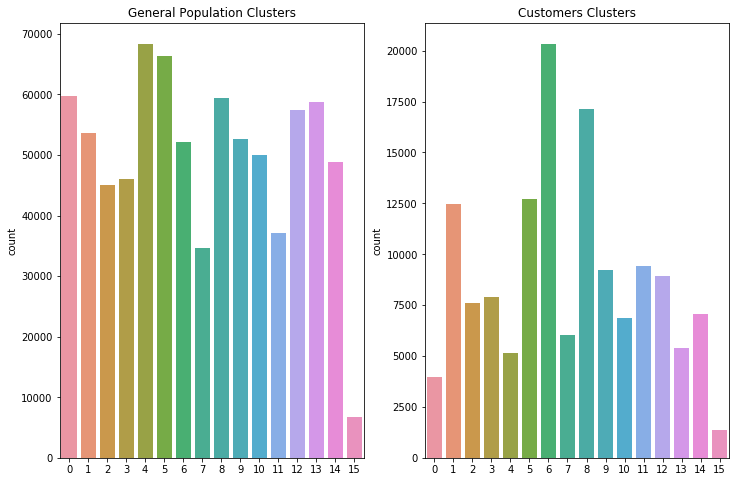

In [109]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

sns.countplot(k_means_pred, ax=ax1)
ax1.set_title('General Population Clusters')

sns.countplot(customers_pred, ax=ax2)
ax2.set_title('Customers Clusters')

In [125]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cust_clust_6 = customers_data_scaler.inverse_transform(pca_40.inverse_transform(k_means.cluster_centers_[6]))


In [126]:
overreprsntd_6 = pd.Series(data = cust_clust_6, index=customers_new.columns)
overreprsntd_6


ALTERSKATEGORIE_GROB                     3.850918
ANREDE_KZ                                0.888862
CJT_GESAMTTYP                            2.619727
FINANZ_MINIMALIST                        5.618722
FINANZ_SPARER                            0.777233
FINANZ_VORSORGER                         5.071419
FINANZ_ANLEGER                           0.603323
FINANZ_UNAUFFAELLIGER                    1.535890
FINANZ_HAUSBAUER                         1.612936
FINANZTYP                                4.968890
GFK_URLAUBERTYP                          5.755566
GREEN_AVANTGARDE                         1.373974
HEALTH_TYP                               1.794277
LP_LEBENSPHASE_FEIN                     32.111137
LP_LEBENSPHASE_GROB                      9.411529
LP_FAMILIE_FEIN                          7.038752
LP_FAMILIE_GROB                          3.708729
LP_STATUS_FEIN                          11.200033
LP_STATUS_GROB                           5.495363
NATIONALITAET_KZ                         0.977227


In [127]:
overreprsntd_6.sort_values(ascending=False)

MIN_GEBAEUDEJAHR                  1993.073776
KBA13_ANZAHL_PKW                   743.900807
LP_LEBENSPHASE_FEIN                 32.111137
LP_STATUS_FEIN                      11.200033
LP_LEBENSPHASE_GROB                  9.411529
WOHNDAUER_2008                       8.992171
LP_FAMILIE_FEIN                      7.038752
SEMIO_VERT                           7.004573
SEMIO_LUST                           6.289207
GFK_URLAUBERTYP                      5.755566
FINANZ_MINIMALIST                    5.618722
LP_STATUS_GROB                       5.495363
ORTSGR_KLS9                          5.397715
SEMIO_SOZ                            5.090532
FINANZ_VORSORGER                     5.071419
FINANZTYP                            4.968890
INNENSTADT                           4.668488
MOBI_REGIO                           4.660469
SEMIO_KULT                           4.587076
SEMIO_FAM                            4.564736
KBA05_GBZ                            4.430914
RETOURTYP_BK_S                    

In [128]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cust_cluster_0 = customers_data_scaler.inverse_transform(pca_40.inverse_transform(k_means.cluster_centers_[0]))


In [129]:
undrreprsnted_0 = pd.Series(data = cust_cluster_0, index = customers_new.columns)


In [130]:
undrreprsnted_0


ALTERSKATEGORIE_GROB                     2.762239
ANREDE_KZ                                0.793305
CJT_GESAMTTYP                            3.512714
FINANZ_MINIMALIST                        3.391348
FINANZ_SPARER                            2.385463
FINANZ_VORSORGER                         3.723008
FINANZ_ANLEGER                           2.122432
FINANZ_UNAUFFAELLIGER                    2.761640
FINANZ_HAUSBAUER                         3.200471
FINANZTYP                                3.199831
GFK_URLAUBERTYP                          7.795339
GREEN_AVANTGARDE                         0.370332
HEALTH_TYP                               2.074996
LP_LEBENSPHASE_FEIN                     16.990936
LP_LEBENSPHASE_GROB                      5.120403
LP_FAMILIE_FEIN                          4.293541
LP_FAMILIE_GROB                          2.559825
LP_STATUS_FEIN                           4.610409
LP_STATUS_GROB                           2.406970
NATIONALITAET_KZ                         1.130163


In [131]:
undrreprsnted_0.sort_values()

SOHO_KZ                                   0.000619
SHOPPER_TYP_2.0                           0.001336
ANZ_TITEL                                 0.013526
ANZ_HH_TITEL                              0.060837
OST_WEST_KZ_O                             0.121725
SHOPPER_TYP_3.0                           0.170098
KBA05_ANTG4                               0.301052
GREEN_AVANTGARDE                          0.370332
SHOPPER_TYP_0.0                           0.389138
SHOPPER_TYP_1.0                           0.443345
PRAEGENDE_JUGENDJAHRE_MOVEMENT            0.622988
KBA05_ANTG3                               0.766178
ANREDE_KZ                                 0.793305
OST_WEST_KZ_W                             0.878275
PLZ8_ANTG4                                0.950117
NATIONALITAET_KZ                          1.130163
KBA05_ANTG1                               1.191126
KBA05_ANTG2                               1.369129
VERS_TYP                                  1.459002
SEMIO_KAEM                     

In [132]:
cust_cluster_4 = customers_data_scaler.inverse_transform(pca_40.inverse_transform(k_means.cluster_centers_[4]))


In [133]:
undrreprsnted_4 = pd.Series(data = cust_cluster_4, index = customers_new.columns)


In [134]:
undrreprsnted_4


ALTERSKATEGORIE_GROB                     2.688211
ANREDE_KZ                                1.790778
CJT_GESAMTTYP                            3.651802
FINANZ_MINIMALIST                        2.877686
FINANZ_SPARER                            2.320930
FINANZ_VORSORGER                         3.778148
FINANZ_ANLEGER                           2.457165
FINANZ_UNAUFFAELLIGER                    2.648182
FINANZ_HAUSBAUER                         3.764148
FINANZTYP                                2.706338
GFK_URLAUBERTYP                          7.821285
GREEN_AVANTGARDE                         0.294292
HEALTH_TYP                               1.954107
LP_LEBENSPHASE_FEIN                     18.613154
LP_LEBENSPHASE_GROB                      5.647900
LP_FAMILIE_FEIN                          4.808727
LP_FAMILIE_GROB                          2.785640
LP_STATUS_FEIN                           4.412409
LP_STATUS_GROB                           2.284239
NATIONALITAET_KZ                         1.145710


In [135]:
undrreprsnted_4.sort_values()

SOHO_KZ                                   0.000796
ANZ_TITEL                                 0.015206
ANZ_HH_TITEL                              0.089384
OST_WEST_KZ_O                             0.127348
SHOPPER_TYP_0.0                           0.130954
SHOPPER_TYP_1.0                           0.138635
SHOPPER_TYP_3.0                           0.248337
GREEN_AVANTGARDE                          0.294292
SHOPPER_TYP_2.0                           0.350309
KBA05_ANTG4                               0.422041
PRAEGENDE_JUGENDJAHRE_MOVEMENT            0.652095
KBA05_ANTG3                               0.740411
OST_WEST_KZ_W                             0.872652
KBA05_ANTG1                               1.053686
NATIONALITAET_KZ                          1.145710
KBA05_ANTG2                               1.146345
PLZ8_ANTG4                                1.150987
VERS_TYP                                  1.436699
PLZ8_ANTG1                                1.674017
ANREDE_KZ                      

In [136]:
cust_cluster_13 = customers_data_scaler.inverse_transform(pca_40.inverse_transform(k_means.cluster_centers_[13]))


In [137]:
undrreprsnted_13 = pd.Series(data = cust_cluster_13, index = customers_new.columns)


In [138]:
undrreprsnted_13


ALTERSKATEGORIE_GROB                     2.846544
ANREDE_KZ                                1.722147
CJT_GESAMTTYP                            3.609472
FINANZ_MINIMALIST                        3.265407
FINANZ_SPARER                            2.247852
FINANZ_VORSORGER                         3.845713
FINANZ_ANLEGER                           2.668588
FINANZ_UNAUFFAELLIGER                    2.802563
FINANZ_HAUSBAUER                         3.115375
FINANZTYP                                2.759799
GFK_URLAUBERTYP                          7.461851
GREEN_AVANTGARDE                         0.346471
HEALTH_TYP                               2.059080
LP_LEBENSPHASE_FEIN                     16.028296
LP_LEBENSPHASE_GROB                      4.565684
LP_FAMILIE_FEIN                          3.332604
LP_FAMILIE_GROB                          2.181599
LP_STATUS_FEIN                           5.935515
LP_STATUS_GROB                           2.870404
NATIONALITAET_KZ                         1.099815


In [139]:
undrreprsnted_13.sort_values()

SOHO_KZ                                   0.000712
ANZ_TITEL                                 0.015074
KBA05_ANTG4                               0.018617
OST_WEST_KZ_O                             0.023339
ANZ_HH_TITEL                              0.023952
SHOPPER_TYP_0.0                           0.141531
SHOPPER_TYP_1.0                           0.223382
SHOPPER_TYP_2.0                           0.243542
PLZ8_ANTG4                                0.243921
KBA05_ANTG3                               0.262362
SHOPPER_TYP_3.0                           0.266416
GREEN_AVANTGARDE                          0.346471
PRAEGENDE_JUGENDJAHRE_MOVEMENT            0.577817
OST_WEST_KZ_W                             0.976661
PLZ8_BAUMAX                               0.987033
PLZ8_ANTG3                                1.010206
NATIONALITAET_KZ                          1.099815
VERS_TYP                                  1.421282
KBA05_ANTG2                               1.552110
ANZ_PERSONEN                   

### Discussion 3.3: Compare Customer Data to Demographics Data

As per our analysis, the cluster 6 is overrepresented in the customers data as compared to the general population
and the segemtns that are popular are :

* MIN_GEBAEUDEJAHR                  
* KBA13_ANZAHL_PKW                   

Clusters 0, 4, & 13 are underrepresented in the customers data as compared to the general population
and the segemtns that are not popular are :

* SOHO_KZ                                   
* SHOPPER_TYP_2.0                           
* ANZ_TITEL


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.